In [127]:
import numpy as np
from scipy import fftpack
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import ghibtools as gh

In [4]:
def generate_wavelet_fourier(len_wavelet, f_start, f_stop, delta_freq, sampling_rate, f0, normalisation):
    """
    Compute the wavelet coefficients at all scales and makes its Fourier transform.
    When different signal scalograms are computed with the exact same coefficients, 
        this function can be executed only once and its result passed directly to compute_morlet_scalogram
        
    Output:
        wf : Fourier transform of the wavelet coefficients (after weighting), Fourier frequencies are the first 
    """
    # compute final map scales
    scales = f0/np.arange(f_start,f_stop,delta_freq)*sampling_rate
    # compute wavelet coeffs at all scales
    xi=np.arange(-len_wavelet/2.,len_wavelet/2.)
    xsd = xi[:,np.newaxis] / scales
    wavelet_coefs=np.exp(complex(1j)*2.*np.pi*f0*xsd)*np.exp(-np.power(xsd,2)/2.)

    weighting_function = lambda x: x**(-(1.0+normalisation))
    wavelet_coefs = wavelet_coefs*weighting_function(scales[np.newaxis,:])

    # Transform the wavelet into the Fourier domain
    #~ wf=fft(wavelet_coefs.conj(),axis=0) <- FALSE
    wf=fftpack.fft(wavelet_coefs,axis=0)
    wf=wf.conj() # at this point there was a mistake in the original script
    
    return wf


def convolve_scalogram(sig, wf):
    """
    Convolve with fft the signal (in time domain) with the wavelet
    already computed in freq domain.
    
    Parameters
    ----------
    sig: numpy.ndarray (1D, float)
        The signal
    wf: numpy.array (2D, complex)
        The wavelet coefficient in fourrier domain.
    """
    n = wf.shape[0]
    assert sig.shape[0]<=n, 'the sig.size is longer than wf.shape[0] {} {}'.format(sig.shape[0], wf.shape[0])
    sigf=fftpack.fft(sig,n)
    wt_tmp=fftpack.ifft(sigf[:,np.newaxis]*wf,axis=0)
    wt = fftpack.fftshift(wt_tmp,axes=[0])
    return wt

In [8]:
def load_data(patient = 'P1'):
    input_file = f'../dataarray/da_staged_{patient}.nc'
    da = xr.load_dataarray(input_file)
    return da.sel(stage = 'N2').dropna('time')

In [9]:
da = load_data()

In [10]:
da

<xarray.DataArray (chan: 11, time: 3194880)>
array([[ 3.13134303e+01,  3.86478734e+01,  3.83524507e+01, ...,
         1.81413427e+00,  1.72348933e+00,  1.81322367e-01],
       [ 5.48675394e+01,  5.44219338e+01,  5.61424269e+01, ...,
         6.83400627e+01,  6.71567141e+01,  6.63781168e+01],
       [-5.92711604e+01, -5.92672560e+01, -6.20663529e+01, ...,
        -8.49818408e+01, -8.47380231e+01, -8.49905760e+01],
       ...,
       [-1.28083047e+00, -1.27932953e+00, -1.48764108e+00, ...,
        -3.97778256e+00, -4.01205209e+00, -3.99566491e+00],
       [-1.96750352e+02, -2.02268877e+02, -1.98933682e+02, ...,
         1.10715223e+02,  1.12809254e+02,  1.09598537e+02],
       [-2.72052704e+02, -2.68389225e+02, -2.66473610e+02, ...,
         3.35758230e+02,  3.60476193e+02,  3.82445432e+02]])
Coordinates:
  * time     (time) float64 0.0 0.003906 0.007812 ... 1.248e+04 1.248e+04
  * chan     (chan) object 'Fp2-C4' 'C4-T4' 'T4-O2' ... 'DEBIT' 'THERM' 'ECG'
    stage    <U2 'N2'

In [16]:
sig = da[0,:].values

In [32]:
wf = generate_wavelet_fourier(len_wavelet=sig.size, f_start=10, f_stop=20, delta_freq=1, sampling_rate=256, f0=5, normalisation=0)

In [33]:
wf.shape

(3194880, 10)

In [135]:
wt = convolve_scalogram(sig, wf)

In [136]:
np.abs(wt).shape

(3194880, 10)

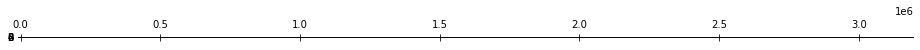

In [137]:
plt.matshow(np.abs(wt).T)